# Plot dv/v time series at single stations
Notebook written by Cody A. Kupres at Purdue University

Reference: Kupres, C. A., Yang, X, Haney M., Roman, D. C. (in review) Sustained co-eruptive increase in seismic velocity below Great Sitkin Volcano due to magma extrusion. Geophysical Research Letters

In [1]:
#IMPORT SECTION
import sys,os,time,glob,scipy
import pandas as pd
from obspy import UTCDateTime
import pyasdf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.pylab as pl
import matplotlib.lines as mlines
from scipy.optimize import curve_fit
from seisgo import noise, monitoring, utils
import seisgo.plotting as sp
import seisgo.downloaders as dld
import pickle
import datetime 


np.set_printoptions(threshold=sys.maxsize)

In [2]:

# GS VOLCANO
#####FILE LOCATIONS#####
rootpath = "/home/ckupres/volcanodvv" # roothpath for the project
maindirec  = '/home/ckupres/volcanodvv/data_greatsitkin' #main project folder
figdir = os.path.join('Figures')
dvvdir  = os.path.join(maindirec,'dvv_5sta_redo')


In [3]:
###BH FIRST###
sta_list = ['AV.GSSP','AV.GSCK','AV.GSMY','AV.GSTD','AV.GSTR']

method = 'ts'
#FREQUENCIES#
freq = [[1,2]]
comppairlist = ['XC','SC']





###################
###PARAMETERS THAT TYPICALLY DONT NEED CHANGING######
##CHANGE datanum to 'data1' or 'data2'
# to pick positive or negative side
# data1 = negative, data2 = positive
# 'both' will average both sides
datanum = 'both' 
#Change this option
#full window legnth in days
full_window_length = 20

# Minimum correlation coefficient
mincc = 0.75

#Station dictionary
sta_dict = {}

In [18]:
for comppair in comppairlist:
    print(comppair)
    sta_dict[comppair]={}
    for sta in sta_list:
        for freq0 in freq:

                source = sta
                receiver = source
                freqr = freq0
                #Load in all the files for the station pairs
                complist=[]
                if comppair == "XC":
                    #EZ
                    comp1filename = 'dvv.'+source+'.'+receiver+'.'+'EZ'+\
                    '.'+str(freqr[0])+'-'+str(freqr[1])+'Hz'+'.'+method#+'.test'
                    comp1dvvfilepath = os.path.join(dvvdir, comp1filename+'.pk')
                    comp1tempdvvfile1 = monitoring.extract_dvvdata(comp1dvvfilepath, comp='EZ', format = 'pickle')
                    comp1dvvfile = comp1tempdvvfile1[source+'_'+receiver]['EZ']
                    #NZ
                    comp2filename = 'dvv.'+source+'.'+receiver+'.'+'NZ'+\
                    '.'+str(freqr[0])+'-'+str(freqr[1])+'Hz'+'.'+method#+'.test'
                    comp2dvvfilepath = os.path.join(dvvdir, comp2filename+'.pk')
                    comp2tempdvvfile1 = monitoring.extract_dvvdata(comp2dvvfilepath, comp='NZ', format = 'pickle')
                    comp2dvvfile = comp2tempdvvfile1[source+'_'+receiver]['NZ']
                    #EN
                    comp3filename = 'dvv.'+source+'.'+receiver+'.'+'EN'+\
                    '.'+str(freqr[0])+'-'+str(freqr[1])+'Hz'+'.'+method#+'.test'
                    comp3dvvfilepath = os.path.join(dvvdir, comp3filename+'.pk')
                    comp3tempdvvfile1 = monitoring.extract_dvvdata(comp3dvvfilepath, comp='EN', format = 'pickle')
                    comp3dvvfile = comp3tempdvvfile1[source+'_'+receiver]['EN']
                    complist = ['EZ','NZ','EN']
                elif comppair == "SC":
                    #EE
                    comp1filename = 'dvv.'+source+'.'+receiver+'.'+'EE'+\
                    '.'+str(freqr[0])+'-'+str(freqr[1])+'Hz'+'.'+method#+'.test'
                    comp1dvvfilepath = os.path.join(dvvdir, comp1filename+'.pk')
                    comp1tempdvvfile1 = monitoring.extract_dvvdata(comp1dvvfilepath, comp='EE', format = 'pickle')
                    comp1dvvfile = comp1tempdvvfile1[source+'_'+receiver]['EE']
                    #NN
                    comp2filename = 'dvv.'+source+'.'+receiver+'.'+'NN'+\
                    '.'+str(freqr[0])+'-'+str(freqr[1])+'Hz'+'.'+method#+'.test'
                    comp2dvvfilepath = os.path.join(dvvdir, comp2filename+'.pk')
                    comp2tempdvvfile1 = monitoring.extract_dvvdata(comp2dvvfilepath, comp='NN', format = 'pickle')
                    comp2dvvfile = comp2tempdvvfile1[source+'_'+receiver]['NN']
                    #ZZ
                    comp3filename = 'dvv.'+source+'.'+receiver+'.'+'ZZ'+\
                    '.'+str(freqr[0])+'-'+str(freqr[1])+'Hz'+'.'+method#+'.test'
                    comp3dvvfilepath = os.path.join(dvvdir, comp3filename+'.pk')
                    comp3tempdvvfile1 = monitoring.extract_dvvdata(comp3dvvfilepath, comp='ZZ', format = 'pickle')
                    comp3dvvfile = comp3tempdvvfile1[source+'_'+receiver]['ZZ']
                    complist = ['EE','NN','ZZ']

                dvvfilelist = [comp1dvvfile,comp2dvvfile,comp3dvvfile]
                compdict = {}
                for idx, compfile in enumerate(dvvfilelist):
                ###OPTION 1####
                ###pick the dvv file to use
                    dvvdata = compfile

                    if datanum is None:
                        neg = sum(dvvdata.maxcc1)/len(dvvdata.maxcc1)
                        pos = sum(dvvdata.maxcc2)/len(dvvdata.maxcc2)
                        if neg >= pos:
                            datanum = 'data1'
                        else:
                            datanum = 'data2'


                    ###########################################################
                    posneg = ''
                    ####################### ts ###############################
                    #####low correlation coeffecients
                    method == 'ts'
                    maxerr = 1
                    if datanum == 'data1':
                        posneg = '(negative)'

                        data1temp = dvvdata.data1
                        data1temp[dvvdata.maxcc1 <= mincc ] = np.nan
                        data1temp[dvvdata.error1 >= maxerr ] = np.nan
                        data = data1temp

                    elif datanum == 'data2':
                        posneg = '(positive)'

                        data2temp = dvvdata.data2
                        data2temp[dvvdata.maxcc2 <= mincc ] = np.nan
                        data2temp[dvvdata.error2 >= maxerr ] = np.nan
                        data = data2temp

                    elif datanum == 'both':
                        posneg = ''

                        data1temp = dvvdata.data1
                        data1temp[dvvdata.maxcc1 <= mincc ] = np.nan
                        data1temp[dvvdata.error1 >= maxerr ] = np.nan
                        data1=data1temp

                        data2temp = dvvdata.data2
                        data2temp[dvvdata.maxcc2 <= mincc ] = np.nan
                        data2temp[dvvdata.error2 >= maxerr ] = np.nan
                        data2=data2temp

                        data = (data1+data2)/2

                    freqrange = freqr

                    ############################################################

                    ####Creating a date list of numbers to
                    #### be used in the scipy.optimize.curve_fit
                    ####getting datetime from the data###
                    dates = dvvdata.time

                    numdatelist0 = []
                    for i in dates:
                        numdatelist0.append(i)

                    strdatelist0 = []
                    for i in range(len(dates)):
                        da = datetime.datetime.utcfromtimestamp(dates[i]).strftime('%Y-%m-%d %H:%M')
                        strdatelist0.append(da)


                    ###get the mean from the frequency band###
                    ############### for wts ##################
                    ### this has no effect if method used is
                    ## ts. Leave it if ts because datalist is
                    ## the variable used to calculate curve_fit
                    datalist0 = []
                    for i in range(len(data)):
                        datamean = np.average(data[i])
                        datalist0.append(datamean)

                    ## Removing NaN values and their associated dates
                    ## by indices

                    datalist = []
                    numdatelist = []
                    strdatelist = []
                    datesremoved = []

                    for i in range(len(dates)):
                        datapoint = datalist0[i]
                        if np.isnan(datapoint) == False:
                            datalist.append(datalist0[i])
                            numdatelist.append(numdatelist0[i])
                            strdatelist.append(strdatelist0[i])
                        else:
                            datesremoved.append(strdatelist0[i])

                    ### MDATES
                    mdateslist = list(mdates.date2num(strdatelist))


                    #How many point where removed

                    print("Number of data points remaining:",len(datalist))
                    print("NaN points detected and removed:",len(datalist0)-len(datalist))
                    print()
                    #print('Dates Removed:',datesremoved)

                    ##detrend data
                    # data_0 = utils.detrend(utils.demean(np.array(datalist)))
                    data_0 = np.array(datalist)

                    ## Calculating the Moving Window Mean
                    # Original resolution is 12 hours
                    #It may seem redundent but the first '2' is for the resolution being a 1/2 day
                    # and converting it to a full day. The second '2' is cutting the window to only
                    #one side. keep both for clarity and if you need to, change the original resolution
                    window = 2*int(full_window_length/2)
                    compdata = data_0
                    compmdateslist = mdateslist

                    compdict[complist[idx]] = [compmdateslist, compdata]
                #########################################################
                #################  dvv data compiling.  #################
                #########################################################
                ### 3 comp average data plot
                def range_inc(start, stop, step):
                    i = start
                    while i < stop:
                        yield i
                        i += step

                dateslength=max(len(compdict[complist[0]][0]),len(compdict[complist[1]][0]),\
                                len(compdict[complist[2]][0]))

                threecompdates_0 = list(range_inc(mdates.datestr2num("2019-07-01"),mdates.datestr2num("2023-07-31"),.5))
                threecompdata_0 = []

                for idx, date3comp in enumerate(threecompdates_0):
                    x = np.nan
                    y = np.nan
                    z = np.nan
                    if date3comp in compdict[complist[0]][0]:
                        comp1idx = compdict[complist[0]][0].index(date3comp)
                        x = compdict[complist[0]][1][comp1idx]
                    if date3comp in compdict[complist[1]][0]:
                        comp2idx = compdict[complist[1]][0].index(date3comp)
                        y= compdict[complist[1]][1][comp2idx]
                    if date3comp in compdict[complist[2]][0]:
                        comp3idx = compdict[complist[2]][0].index(date3comp)
                        z = compdict[complist[2]][1][comp3idx]
                    threecompdata_0.append(np.nanmean([x,y,z]))
                    
                #removing Nans and associated dates for MWM
                threecompdates = []
                threecompdata = []

                for idx, val in enumerate(threecompdata_0):
                    if np.isnan(val) == False:
                        threecompdata.append(threecompdata_0[idx])
                        threecompdates.append(threecompdates_0[idx])



                data_MWM = utils.moving_ave(np.array(threecompdata),window)
                sta_dict[comppair][sta] = [threecompdates,data_MWM]

XC
Number of data points remaining: 1101
NaN points detected and removed: 1722

Number of data points remaining: 1326
NaN points detected and removed: 1493

Number of data points remaining: 2527
NaN points detected and removed: 313



/depot/xtyang/apps/seisgo/lib/python3.7/site-packages/ipykernel_launcher.py:206: RuntimeWarning: Mean of empty slice


Number of data points remaining: 2574
NaN points detected and removed: 210

Number of data points remaining: 1132
NaN points detected and removed: 1632

Number of data points remaining: 2539
NaN points detected and removed: 245

Number of data points remaining: 2130
NaN points detected and removed: 711

Number of data points remaining: 1587
NaN points detected and removed: 239

Number of data points remaining: 1659
NaN points detected and removed: 170

Number of data points remaining: 190
NaN points detected and removed: 2753

Number of data points remaining: 976
NaN points detected and removed: 1967

Number of data points remaining: 2453
NaN points detected and removed: 496

Number of data points remaining: 2246
NaN points detected and removed: 480

Number of data points remaining: 2334
NaN points detected and removed: 399

Number of data points remaining: 1715
NaN points detected and removed: 1029

SC
Number of data points remaining: 2896
NaN points detected and removed: 5

Number of

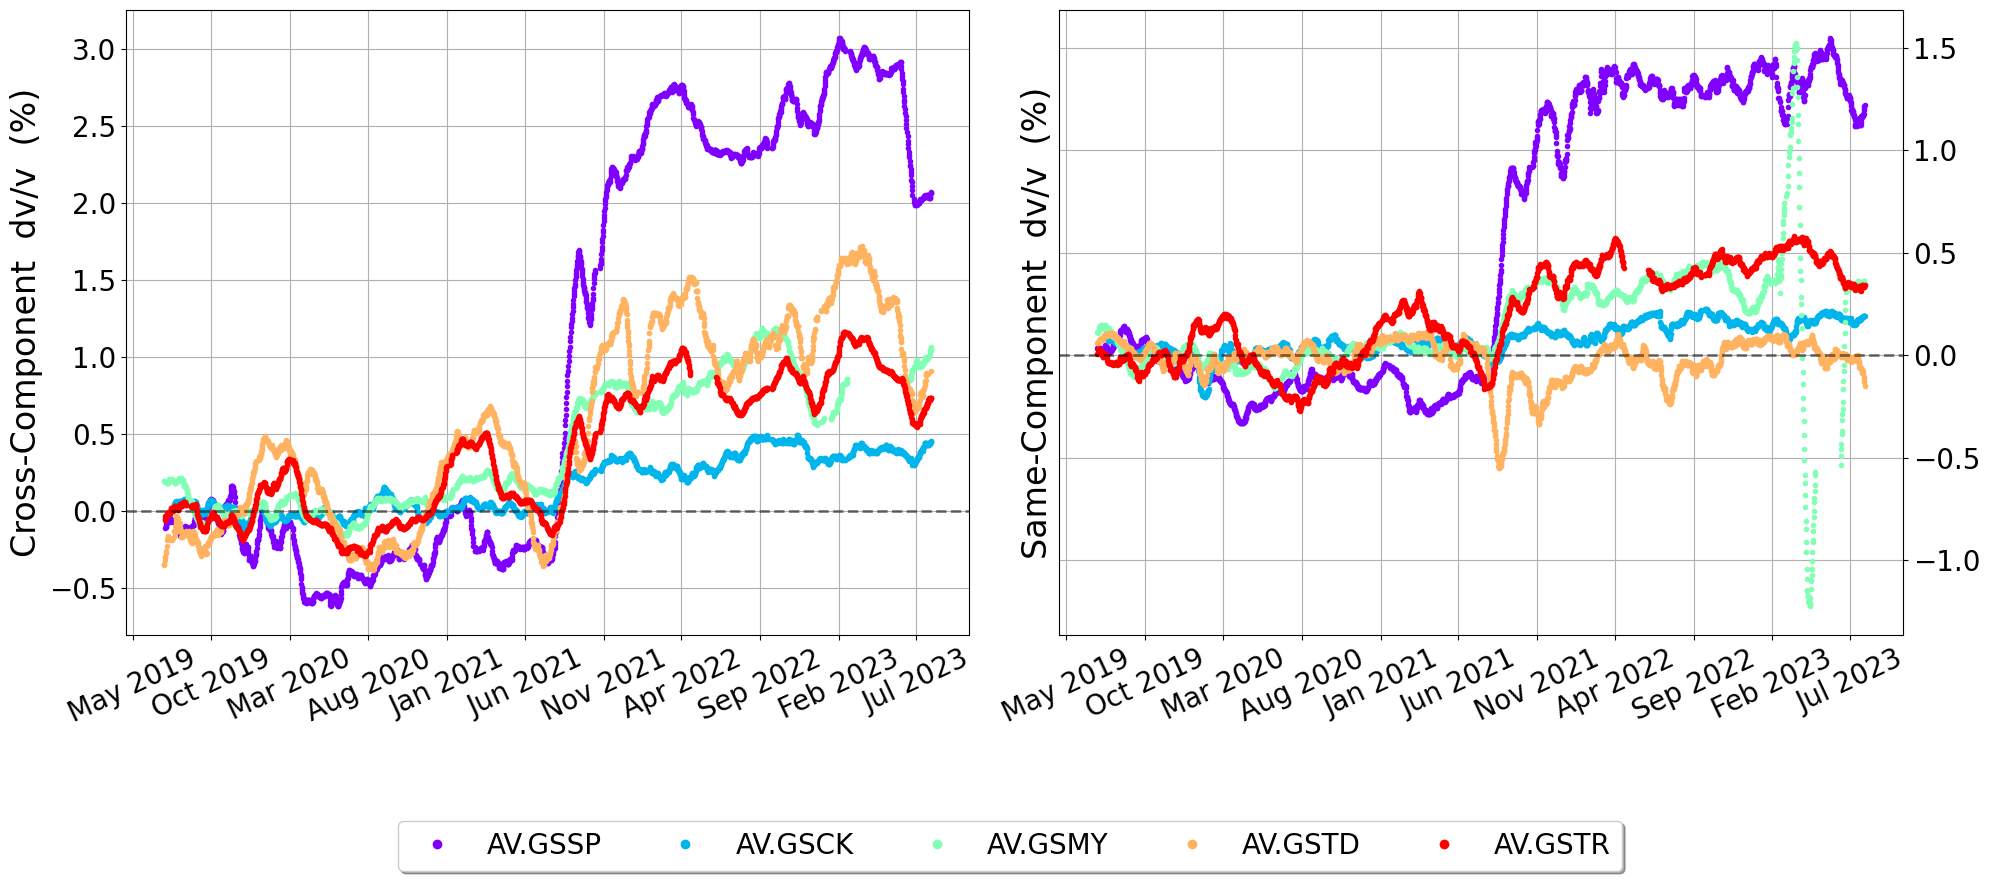

In [20]:
##########FULL DATA RANGE##############
##########PLOTTING######################
dvv_fig, ax = plt.subplots(1,2,figsize = (20,8), facecolor = 'white')


color = pl.cm.rainbow(np.linspace(0,1,len(sta_dict['XC'])))
for i,comp in enumerate(comppairlist):
    for idx,sta in enumerate(sta_dict[comp]):
         ax[i].plot(sta_dict[comp][sta][0], sta_dict[comp][sta][1],'o',markersize=3,\
                  color = color[idx], label = sta)


# dv/v plotting results

for i,comp in enumerate(comppairlist):
    ax[i].axhline(0,linewidth = 2, linestyle = '--', color = "black", alpha = .5)
    
#     ax[i].set_xlim(18078.0+full_window_length, np.max(sta_dict[comp][key][0])-full_window_length)
    
    ##
    ax[i].grid()
    #ax[i].label_outer()
    fontsize = 20
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax[i].xaxis.set_major_locator(mdates.MonthLocator(interval=5))
    ax[i].tick_params(axis='x', labelsize=fontsize)
    ax[i].tick_params(axis = 'y', labelsize=fontsize)

    
    


ax[0].set_ylabel('Cross-Component  dv/v  (%)', fontsize = 24)
ax[1].set_ylabel('Same-Component  dv/v  (%)', fontsize = 24)
ax[1].yaxis.tick_right()
            

# figname = '2-3 Hz'

#dvv_fig.supylabel(x=0,y=0.58,t='dv/v %', fontsize = 24)
# dvv_fig.suptitle(figname, fontsize =24)
dvv_fig.tight_layout()
dvv_fig.autofmt_xdate(rotation=25, ha='center')
plt.legend(loc='lower center',markerscale=2, bbox_to_anchor=(-.058, -0.4),
             ncol=5, fancybox=True,shadow=True, prop={'size':fontsize})